# Verify Physics and Visualization

This notebook executes the standalone experiment scripts (`experiments/run_2d.py` and `experiments/run_3d.py`) and visualizes their output artifacts (Temperature fields, Material Phase masks, and 3D animations).

In [1]:
import sys
from pathlib import Path

from IPython.display import HTML, IFrame, Image, display

# Ensure project root is in path
project_root = Path("../").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import Experiment Runners
from experiments.run_2d import run_2d_experiment
from experiments.run_3d import run_3d_experiment

# Import Configuration Schemas
from src.neural_pbf.core.config import LengthUnit, SimulationConfig
from src.neural_pbf.physics.material import MaterialConfig
from src.neural_pbf.scan.sources import GaussianSourceConfig

## 1. Run 2D Experiment
Simulates a single laser track on a 2D surface. Verifies physics stability and material phase transitions.

In [2]:
# Run the 2D experiment
print("Starting 2D Experiment...")
run_2d_dir = run_2d_experiment()
print(f"2D Experiment finished. Artifacts in: {run_2d_dir}")

Starting 2D Experiment...
Using device: cuda
Running 2D Sim: 400 steps, dt=2.00e-06s
Step 0/400 | T_max=352.4 K
Step 100/400 | T_max=2506.7 K
Step 200/400 | T_max=2583.4 K
Step 300/400 | T_max=2571.0 K
2D Experiment Complete. Results in artifacts/run_2d_20260121_232138
2D Experiment finished. Artifacts in: artifacts/run_2d_20260121_232138


### 2D Visualization Results
Below are the generated plots: XT-Diagram (Space-Time) and Material/Temperature Snapshots.

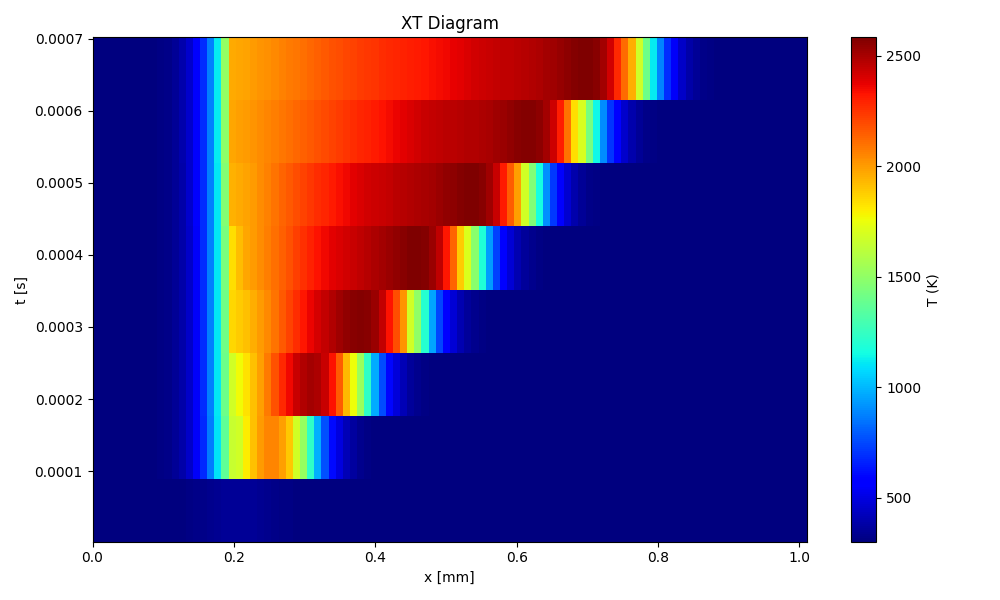

In [3]:
if run_2d_dir:
    plots_dir = run_2d_dir / "plots" / "png"

    # XT Diagram
    xt_path = plots_dir / "xt_diagram.png"
    if xt_path.exists():
        display(HTML("<h3>XT Diagram</h3>"))
        display(Image(filename=str(xt_path)))

    # Material Overlays (Last few steps)
    overlays = sorted(list(plots_dir.glob("material_overlay_step_*.png")))
    if overlays:
        display(
            HTML(f"<h3>Material Overlays ({len(overlays)} snapshots generated)</h3>")
        )
        # Show first, middle, last
        indices = [0, len(overlays) // 2, -1]
        for i in indices:
            if i < len(overlays):
                p = overlays[i]
                display(HTML(f"<b>{p.name}</b>"))
                display(Image(filename=str(p), width=800))

## 2. Run 3D Experiment
Simulates a laser track in a 3D volume. Verifies volumetric heat source and boundary conditions.

In [4]:
# Run the 3D experiment
print("Starting 3D Experiment...")
run_3d_dir = run_3d_experiment()
print(f"3D Experiment finished. Artifacts in: {run_3d_dir}")

Starting 3D Experiment...
Using device: cuda
Running 3D Sim: 300 steps, dt=2.00e-06s
Step 0/300 | T_max=352.3 K
Step 50/300 | T_max=1824.4 K
Step 100/300 | T_max=2044.3 K
Step 150/300 | T_max=2059.4 K
Step 200/300 | T_max=2060.5 K
Step 250/300 | T_max=2061.0 K
3D Experiment Complete. Results in artifacts/run_3d_20260121_232141
3D Experiment finished. Artifacts in: artifacts/run_3d_20260121_232141


### 3D Visualization Results
Includes a 3D animated GIF and interactive volume rendering.

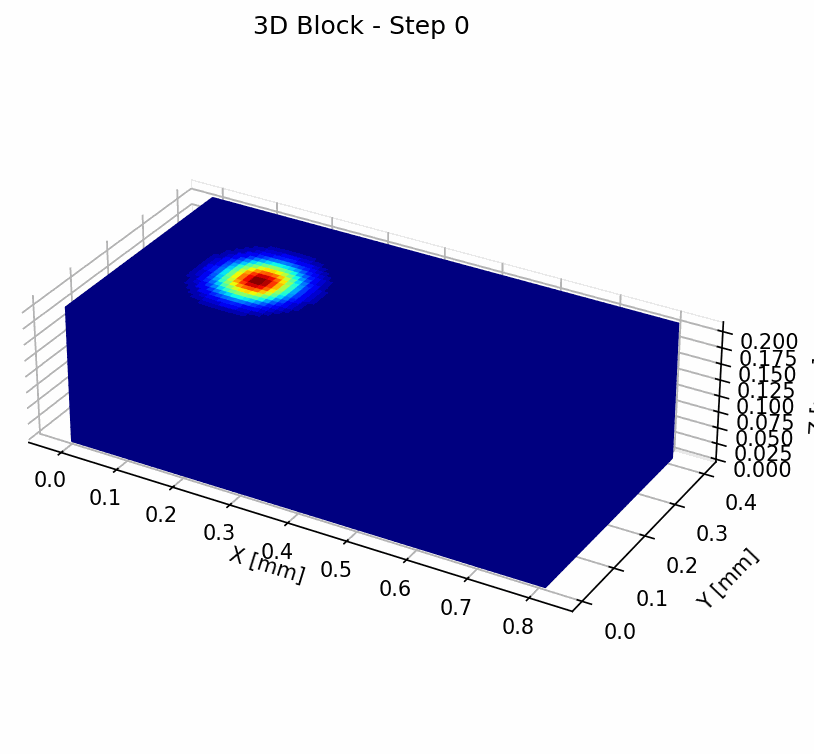

In [5]:
if run_3d_dir:
    plots_dir = run_3d_dir / "plots" / "png"
    interactive_dir = run_3d_dir / "plots" / "interactive"

    # GIF Animation
    gif_path = plots_dir / "animation_3d.gif"
    if gif_path.exists():
        display(HTML("<h3>3D Thermal Animation</h3>"))
        display(Image(filename=str(gif_path)))
    else:
        print(f"No animation found at {gif_path}")

    # Interactive Plots
    htmls = sorted(list(interactive_dir.glob("step_*.html")))
    if htmls:
        latest_html = htmls[-1]
        display(HTML(f"<h3>Interactive Volume Render ({latest_html.name})</h3>"))
        # Using IFrame to prevent JS conflicts and ensure proper rendering
        display(IFrame(src=str(latest_html), width=900, height=600))
    else:
        print(f"No interactive plots found in {interactive_dir}")

## 3. Custom Configuration Experiments

We can now pass custom configuration objects to the experiment runners. 
This allows identifying stable process windows without modifying the source code.

In [3]:
# Define Custom Configurations
custom_sim_cfg = SimulationConfig(
    Lx=0.8,
    Ly=0.4,
    Lz=None,  # Smaller domain
    Nx=80,
    Ny=40,
    Nz=1,
    dt_base=2e-6,
    length_unit=LengthUnit.MILLIMETERS,
)

# Override specific properties, keep others from a 'standard' definition
# Since MaterialConfig requires all fields, we explicitly define them here.
custom_mat_cfg = MaterialConfig(
    k_powder=0.2,  # [W/(m K)]
    k_solid=25.0,  # Custom: Higher conductivity (Default is ~15-20)
    k_liquid=50.0,  # Custom: Higher conductivity
    cp_base=500.0,  # [J/(kg K)]
    rho=7900.0,  # [kg/m^3]
    T_solidus=1650.0,  # [K]
    T_liquidus=1700.0,  # [K]
    latent_heat_L=2.7e5,  # [J/kg]
)

# Run 2D with Custom Configs
print("Running Custom 2D Experiment...")
custom_2d_dir = run_2d_experiment(
    sim_cfg=custom_sim_cfg,
    mat_cfg=custom_mat_cfg,
    run_name="custom_2d_run",
    scan_speed=0.6,  # Slower scan
    total_time=1.0e-3,  # Longer time
)
print(f"Custom Run Saved to: {custom_2d_dir}")

Running Custom 2D Experiment...
Using device: cuda
Running 2D Sim: 500 steps, dt=2.00e-06s
Step 0/500 | T_max=352.5 K
Step 100/500 | T_max=2563.2 K
Step 200/500 | T_max=3079.7 K
Step 300/500 | T_max=3169.7 K
Step 400/500 | T_max=3179.9 K
2D Experiment Complete. Results in artifacts/custom_2d_run
Custom Run Saved to: artifacts/custom_2d_run


## 4. High-Fidelity 3D Simulation (High VRAM Usage)

This configuration uses a much finer grid to capture small-scale thermal gradients. 
It is designed to utilize Available VRAM (e.g., 16GB) more fully.

**Note:** This simulation will take significantly longer to complete.

In [ ]:
# High-Fidelity Configuration with Optimized Physics
# Grid: 512 x 256 x 128 (Adjust Nx/Ny/Nz if OOM occurs)
high_res_sim = SimulationConfig(
    Lx=1.0,
    Ly=0.5,
    Lz=0.25,
    Nx=512,
    Ny=256,
    Nz=128,
    dt_base=2e-6,  # Solver uses adaptive sub-stepping!
    length_unit=LengthUnit.MILLIMETERS,
)

# Optimized Material (Higher Conductivity for Viz, Lower Cp for Melting)
opt_mat_cfg = MaterialConfig(
    k_powder=0.5,  # Helps diffusion viz
    k_solid=25.0,  # SS316L High T
    k_liquid=50.0,  # Convection approximation
    cp_base=450.0,  # Faster heating
    rho=7800.0,
    T_solidus=1600.0,
    T_liquidus=1700.0,
    latent_heat_L=2.0e5,
    transition_sharpness=5.0,
)

# High Power Source to ensure strong melt pool & wake
opt_source_cfg = GaussianSourceConfig(
    power=250.0,  # 250 W
    eta=0.45,
    sigma=35e-6,  # Sharp beam
    depth=60e-6,
)

print("Starting High-Fidelity 3D Experiment (Optimized)...")
try:
    hi_res_dir = run_3d_experiment(
        sim_cfg=high_res_sim,
        mat_cfg=opt_mat_cfg,
        source_cfg=opt_source_cfg,
        run_name="high_fidelity_3d_opt",
        scan_speed=0.8,
        total_time=0.6e-3,
    )
    print(f"High-Fidelity Run Saved to: {hi_res_dir}")
except RuntimeError as e:
    if "out of memory" in str(e):
        print("OOM Error! Try reducing Nx/Ny/Nz slightly.")
    else:
        raise e

Starting High-Fidelity 3D Experiment (Optimized)...
Using device: cuda
Running 3D Sim: 300 steps, dt=2.00e-06s
Step 0/300 | T_max=438.6 K
Step 50/300 | T_max=2921.5 K
Step 100/300 | T_max=3463.7 K
Step 150/300 | T_max=3596.6 K


## 5. Visualizing Cross-Sections and Composite Views

The latest update adds detailed cross-sections (XY, XZ, YZ) and a composite view (3D + slices) to help analyze the heat source profile and melt pool depth.

In [ ]:
from IPython.display import Image, display

# Note: replace 'high_fidelity_3d_opt' with your actual run name if different
run_dir = Path("artifacts/high_fidelity_3d_opt")
step = 350  # Or any step you have multiple of 50

print(f"Viewing results for {run_dir} at step {step}")

cross_path = run_dir / f"plots/png/step_{step:06d}_cross.png"
comp_path = run_dir / f"plots/png/step_{step:06d}_composite.png"

if cross_path.exists():
    print("Cross-Sections (XY, XZ, YZ):")
    display(Image(filename=str(cross_path)))

if comp_path.exists():
    print("\nComposite View (3D Block + Slices):")
    display(Image(filename=str(comp_path)))
else:
    print(
        f"Artifacts not found in {run_dir}. Ensure you ran the experiment with high-fidelity settings."
    )

## 6. Interactive Dashboards and Animations

We now generate:
- **`animation_composite.gif`**: An animated version of the 3D + cross-section view.
- **`composite.html`**: An interactive Plotly dashboard with linked 3D volume and heatmaps.

In [ ]:
from IPython.display import IFrame

run_dir = Path("artifacts/high_fidelity_3d_opt")
step = 350

gif_path = run_dir / "plots/png/animation_composite.gif"
html_path = run_dir / f"plots/interactive/step_{step:06d}_composite.html"

if gif_path.exists():
    print("Composite Animation (GIF):")
    display(Image(filename=str(gif_path)))

if html_path.exists():
    print(f"\nInteractive Dashboard (Step {step}):")
    # Using IFrame to display the Plotly HTML
    display(IFrame(src=str(html_path), width="100%", height="850px"))
else:
    print(
        "Interactive artifact not found. Check if 'html_every_n_steps' is enabled in ArtifactConfig."
    )